# Hybrid flow shop

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/PyJobShop/PyJobShop/blob/main/examples/hybrid_flow_shop.ipynb)

> If you're using this notebook in Google Colab, be sure to install PyJobShop first by executing ```pip install pyjobshop``` in a cell.

In this notebook, we demonstrate how to model and solve a hybrid flow shop (HFS) problem using PyJobShop.

The HFS is a common manufacturing environment in practice and widely studied by scheduling researchers. See for example the surveys by [Ruiz and Vázquez-Rodríguez (2010)](https://www.sciencedirect.com/science/article/pii/S0377221709006390) and [Ribas et al. (2010)](https://www.sciencedirect.com/science/article/pii/S0305054809002883) for an overview of HFS studies.

## Problem description
The HFS problem is characterized as follows:

- There is a set of $n$ jobs that need to be processed in a series of stages.
- The number of processing stages is at least 2.
- Each stage has at least one machine in parallel, and in at least one stage there is more than one machine.
- All jobs are processed in the same production order: production starts in stage 1, then stage 2, etc. until the last stage. A job can only start processing when it has finished processing in the previous stage.

The figure below illustrates a small HFS example with three jobs and three stages. The first and third stage have three machines, and the second stage has two machines.

![HFS](../assets/hybrid-flow-shop.png "HFS")

We can model an HFS problem using PyJobShop. For each job $j$ and each stage $k$, we define a task $t_{jk}$. Moreover, we need to ensure that the previous task $t_{j, k-1}$ is processed before $t_{jk}$ for $k > 1$, which is also known as a _precedence constraint_.

Let's now implement the above example using PyJobShop's Model interface.

## Model

In [1]:
num_jobs = 8
num_stages = 3
num_machines = [2, 3, 2]

In [2]:
import random

random.seed(42)

PROCESSING_TIMES = {
    (job, stage): random.randint(5, 15)
    for job in range(num_jobs)
    for stage in range(num_stages)
}

The following will be helpful to plot labels with $\LaTeX$ typesetting.

In [3]:
def machine_name(machine, stage):
    return f"$M_{{{machine}{stage}}}$"


def job_name(job: int, stage: int):
    return f"$t_{{{job}{stage}}}$"

In [4]:
from pyjobshop import Model

model = Model()

First define the machine layout:

In [5]:
stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

Now, we need to define jobs and the tasks that have to be scheduled, along with the processing time data and precedence constraints, as mentioned earlier.

In [6]:
jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, name=job_name(j, k)) for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_mode(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        model.add_end_before_start(first, second)

In [7]:
result = model.solve(display=False)
(result.status, result.objective)

(<SolveStatus.OPTIMAL: 'Optimal'>, 55.0)

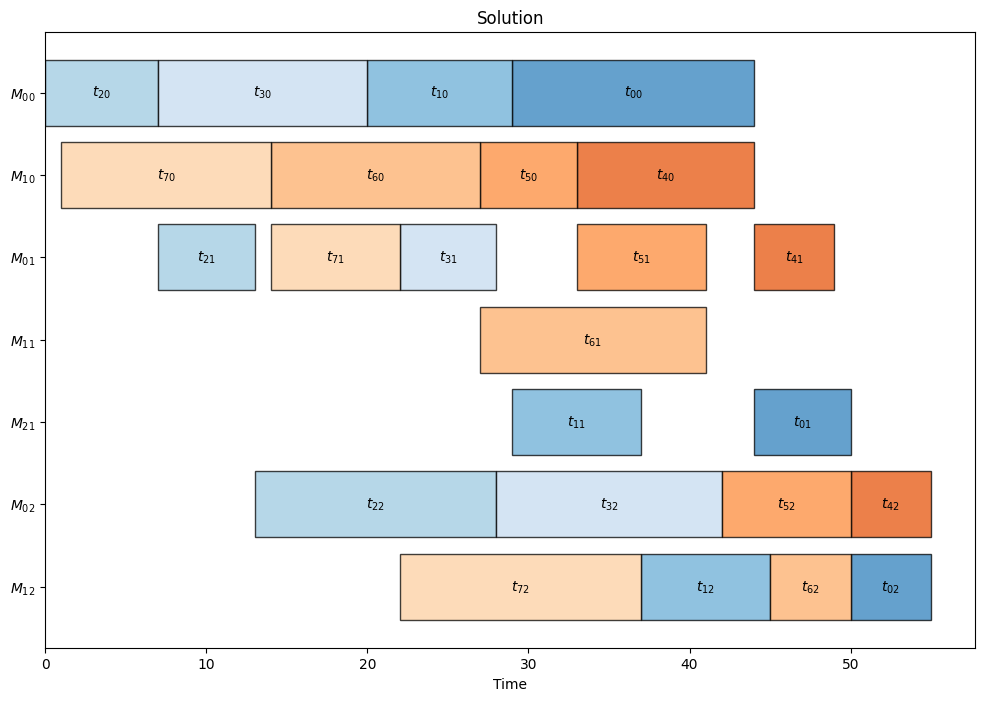

In [8]:
from pyjobshop.plot import plot_machine_gantt

data = model.data()
plot_machine_gantt(result.best, model.data(), plot_labels=True)

## No-wait

What if a job $j$ is not allowed to wait, that is, $t_{jk}$ must start processing exactly when $t_{j,k-1}$ is finished?
This is known in the literature as the _no-wait_ constraint. The way to implement this constraint with PyJobShop is to use `model.add_end_at_start` instead of `model.add_end_before_start` as precedence constraint. Below we define the same model, but with the precedence constraint replaced.

In [9]:
model = Model()

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, name=job_name(j, k)) for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_mode(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        model.add_end_at_start(first, second)

In [10]:
result = model.solve(display=False)
(result.status, result.objective)

(<SolveStatus.OPTIMAL: 'Optimal'>, 56.0)

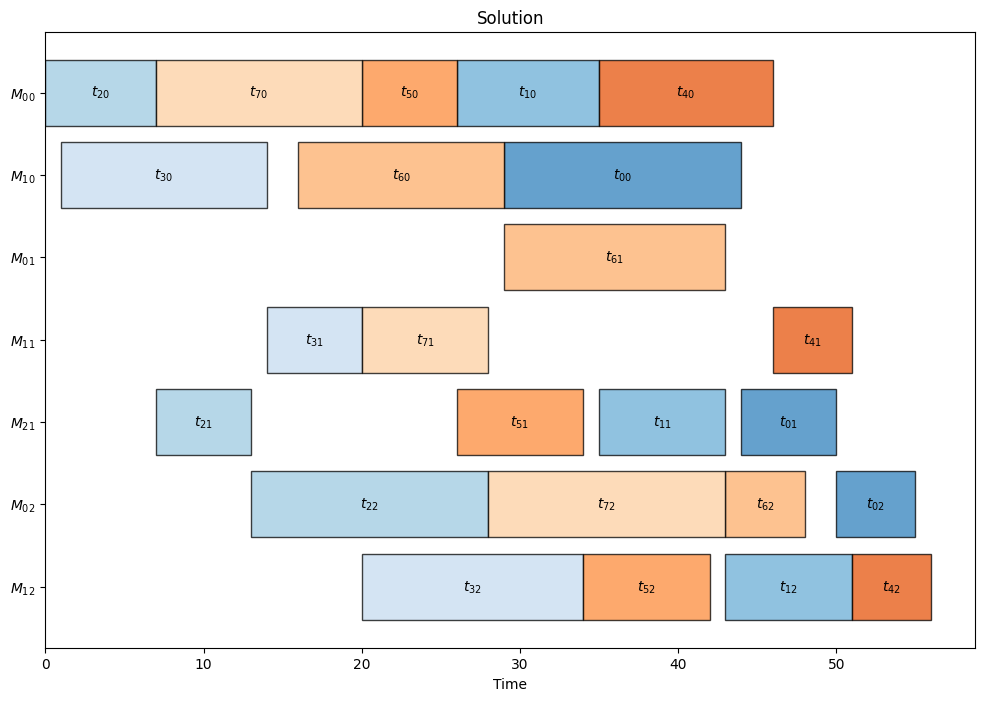

In [11]:
plot_machine_gantt(result.best, model.data(), plot_labels=True)

Note that there is no waiting time between any two tasks belonging to the same job.

## Blocking

Another common constraint in HFS environments is blocking of tasks. In this case, $t_{jk}$ does not need to start right away when $t_{j,k-1}$ is finished, but it will continue to occupy the machine. We can do that by keeping the same constraints as the no-wait setting, but we relax the assumption that tasks have a fixed duration. By default, all tasks have a fixed duration (determined by their processing mode), but in blocking flow shops we can have tasks with variable durations as they depend on whether the machine is blocking or not.  We can do this by setting the `fixed_duration` to `False` for the task. 

In [12]:
model = Model()

stage2machines = {}
for k in range(num_stages):
    stage2machines[k] = [
        model.add_machine(name=machine_name(m, k))
        for m in range(num_machines[k])
    ]

jobs = [model.add_job() for _ in range(num_jobs)]

for j, job in enumerate(jobs):
    tasks = [
        model.add_task(job=job, fixed_duration=False, name=job_name(j, k))
        for k in range(num_stages)
    ]

    for stage in range(num_stages):
        for machine in stage2machines[stage]:
            duration = PROCESSING_TIMES[j, stage]
            model.add_mode(tasks[stage], machine, duration)

    for idx in range(num_stages - 1):
        first = tasks[idx]
        second = tasks[idx + 1]
        model.add_end_before_start(first, second)

In [13]:
result = model.solve(display=False)
(result.status, result.objective)

(<SolveStatus.OPTIMAL: 'Optimal'>, 55.0)

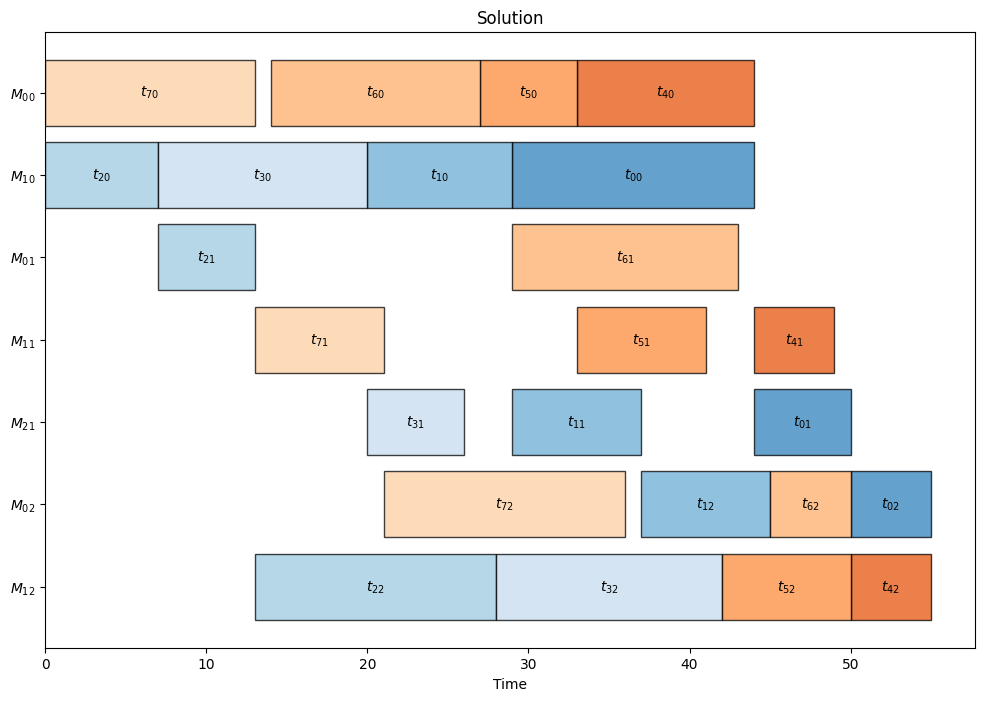

In [14]:
plot_machine_gantt(result.best, model.data(), plot_labels=True)

## Conclusion
This notebooks showed how to model and solve the hybrid flow shop problem using PyJobShop. Specifically, we show how to define the hybrid flow shop problem in terms of tasks and how to add precedence constraints between tasks, which result in no-wait and blocking variants of the problem.